In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math, os, time, copy
import torch.fft as tfft
import pandas as pd
import torch_dct as dct
from numpy import size
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ewaldnn2d import *

torch.random.manual_seed(1234) # for reproducibility

# Global settings
dtype = torch.float64
device = "cpu"
N_batch = 100
N_epochs = 10000
lr = 1e-1 # we will use a LR scheduler, so this is just an initial value
min_delta = 1e-5 # min change in the monitored quantity to qualify as an improvement
patience = 100    # epochs to wait for improvement before stopping training'
pad_mode = "reflect" # in this example, we use reflective padding for local feature generation
N_pow = 1 # number of local features per grid point
N_train = 1500
N_test = 250
N_val = 250
N_energy_terms = 1 # number of energy terms for the LERN model

# grid and basis settings
N_x = 32 # number of grid points in x direction
N_y = N_x # number of grid points in y direction
m_x = torch.arange(0, N_x, dtype=dtype, device=device)             # (N_x,)
m_y = torch.arange(0, N_y, dtype=dtype, device=device)             # (N_y,)
abs_val = torch.sqrt(m_x[:, None]**2 + m_y[None, :]**2)  # (M_x, M_y)
x = torch.linspace(0, 1, N_x, dtype=dtype, device=device)            # (N_x,)
y = torch.linspace(0, 1, N_y, dtype=dtype, device=device)            # (N_y,)
DM_x = torch.cos(torch.pi * torch.outer(m_x, x))                  # (M_x, N_x)
DM_y = torch.cos(torch.pi * torch.outer(m_y, y))                  # (M_y, N_y)
DerDM_x = -torch.pi * m_x[:, None] * torch.sin(torch.pi * torch.outer(m_x, x))  # (M_x, N_x) # derivative of design matrix
DerDM_y = -torch.pi * m_y[:, None] * torch.sin(torch.pi * torch.outer(m_y, y))  # (M_y, N_y) # derivative of design matrix

data_regime = "rough" # "smooth" or "rough"
if data_regime == "smooth":
    M_cutoff = 10 # maximum harmonic   
    std_harm = 2.0 / (1.0 + 0.2 * abs_val)**2 * (abs_val <= M_cutoff).double()  # (M_x, M_y)
elif data_regime == "rough":
    std_harm = 2.0 / (1.0 + 0.0 * abs_val)**2 # (M_x, M_y)
else:
    raise ValueError("regime must be 'smooth' or 'rough'")
std_harm[0, 0] = 0.0 # no uniform density offset

# interaction kernel parameters
qs = 0.5 # screening momentum
amp = 1.0 # amplitude of interaction kernel
kernel_regime = "screened_coulomb"

# unscreened Hartree-Fock total energy function
def E_HF(rho: torch.Tensor, d_rho_x: torch.Tensor, d_rho_y: torch.Tensor, eng_dens_flag: bool = False) -> torch.Tensor:
        return amp * E_int_ms_dct(rho, kernel=kernel_regime, eng_dens_flag=eng_dens_flag, qs=0.0)

# screened total energy function
def E_SC(rho: torch.Tensor, d_rho_x: torch.Tensor, d_rho_y: torch.Tensor, eng_dens_flag: bool = False) -> torch.Tensor:
        return amp * E_int_ms_dct(rho, kernel=kernel_regime, eng_dens_flag=eng_dens_flag, qs=qs)
    
# generate train/test split
flag_generate_data = True # if True, generate new data; if False, load existing data from disk
if flag_generate_data:
    N_batch_int = 10 # number of density profiles per data generation batch
    torch.manual_seed(1234) # for reproducibility
    rho_train, d_rho_x_train, d_rho_y_train, a_train, E_loc_HF_train, E_SC_train = generate_SC_data_2d(N_train, N_batch_int, E_HF, E_SC, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y)
    rho_test, d_rho_x_test, d_rho_y_test, a_test, E_loc_HF_test, E_SC_test = generate_SC_data_2d(N_test, N_batch_int, E_HF, E_SC, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y) 
    rho_val, d_rho_x_val, d_rho_y_val, a_val, E_loc_HF_val, E_SC_val = generate_SC_data_2d(N_val, N_batch_int, E_HF, E_SC, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y)  
    # save data to disk
    os.makedirs("DATA2d", exist_ok=True)

    fname = f"DATA2d/LERN_dataset_{data_regime}_{kernel_regime}_{qs}_{amp}_{N_x}_{N_y}.pt"

    torch.save(
        {
            "rho_train": rho_train,
            "d_rho_x_train": d_rho_x_train,
            "d_rho_y_train": d_rho_y_train,
            "a_train": a_train,
            "E_loc_HF_train": E_loc_HF_train,
            "E_SC_train": E_SC_train,
            "rho_val": rho_val,
            "d_rho_x_val": d_rho_x_val,
            "d_rho_y_val": d_rho_y_val,
            "a_val": a_val,
            "E_loc_HF_val": E_loc_HF_val,
            "E_SC_val": E_SC_val,
            "rho_test": rho_test,
            "d_rho_x_test": d_rho_x_test,
            "d_rho_y_test": d_rho_y_test,
            "a_test": a_test,
            "E_loc_HF_test": E_loc_HF_test,
            "E_SC_test": E_SC_test,
            "data_regime": data_regime,
            "kernel_regime": kernel_regime,
        },
        fname,
    )
else:
    data = torch.load(f"DATA2d/LERN_dataset_{data_regime}_{kernel_regime}_{qs}_{amp}_{N_x}_{N_y}.pt")
    rho_train = data["rho_train"]
    E_loc_HF_train = data["E_loc_HF_train"]
    E_SC_train = data["E_SC_train"]
    rho_test = data["rho_test"]
    E_loc_HF_test = data["E_loc_HF_test"]
    E_SC_test = data["E_SC_test"]
    rho_val = data["rho_val"]
    E_loc_HF_val = data["E_loc_HF_val"]
    E_SC_val = data["E_SC_val"]

features_train = generate_loc_features_rs(rho_train, N_pow=N_pow)  # (N_train, N_x, N_y, N_pow)
features_test  = generate_loc_features_rs(rho_test, N_pow=N_pow)   # (N_test, N_x, N_y, N_pow)
features_val   = generate_loc_features_rs(rho_val, N_pow=N_pow)    # (N_val, N_x, N_y, N_pow)

# Extend features with neighbor information
R_feat = 1.5 # radius for neighbor feature extension
features_train = extend_features_neighbors_2d(features_train, R=R_feat)
features_test  = extend_features_neighbors_2d(features_test, R=R_feat)
features_val   = extend_features_neighbors_2d(features_val, R=R_feat)

# Normalize features
mean_feat, std_feat = compute_normalization_stats(features_train)
features_train_norm = normalize_features(features_train, mean_feat, std_feat)
features_test_norm = normalize_features(features_test, mean_feat, std_feat)
features_val_norm = normalize_features(features_val, mean_feat, std_feat)

# Supplement the features with the unnormalized HF energy term (for the LERN model)
features_train_norm = torch.cat([features_train_norm, E_loc_HF_train], dim=-1)  # (N_train, N_x, N_y, N_feat + 1)
features_test_norm  = torch.cat([features_test_norm,  E_loc_HF_test], dim=-1)   # (N_test,  N_x, N_y, N_feat + 1)
features_val_norm   = torch.cat([features_val_norm,   E_loc_HF_val], dim=-1)    # (N_val,   N_x, N_y, N_feat + 1)

# Normalize targets
E_mean = E_SC_train.mean()
E_std = E_SC_train.std()
E_SC_train_norm = (E_SC_train - E_mean) / E_std
E_SC_test_norm = (E_SC_test - E_mean) / E_std
E_SC_val_norm = (E_SC_val - E_mean) / E_std
# Datasets
train_dataset = TensorDataset(features_train_norm, E_SC_train_norm)
val_dataset   = TensorDataset(features_val_norm,   E_SC_val_norm)
test_dataset  = TensorDataset(features_test_norm,  E_SC_test_norm)
# Loaders
train_loader = DataLoader(train_dataset, batch_size=N_batch, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=N_batch, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=N_batch, shuffle=False, drop_last=False)

_, _, _, N_feat = features_train.shape
print(f"Number of local features per grid point: {N_feat}")

Number of local features per grid point: 9


In [32]:
ckpt_dir = "LearningSC2d_checkpoints"
flag_train = False  # set to True to train models
learning_regime = "LERN2d"

n_hidden_list = [1, 2, 3, 4]
n_neurons_list = [8, 16, 32, 64]

if flag_train:
    for n_hidden in n_hidden_list:
        for n_neurons in n_neurons_list:
            for seed in range(3): # train a few models with different random seeds

                torch.manual_seed(1234 + seed)
                run_name = f"LERN2d_" + data_regime + '_' + kernel_regime + f"_{qs}_{amp}_{N_x}_{N_y}_{N_feat}_{N_energy_terms}_{n_hidden}_{n_neurons}_{seed}"
                print(f"Training model: n_hidden={n_hidden}, n_neurons={n_neurons}, seed={seed}")

                model = LERN2d(
                        N_x=N_x,
                        N_y=N_y,
                        N_energy_terms=N_energy_terms,
                        N_feat=N_feat,
                        n_hidden=n_hidden,
                        n_neurons=n_neurons,
                        mean_feat=mean_feat,
                        std_feat=std_feat,
                        E_mean=E_mean,
                        E_std=E_std,
                    ).to(device=device, dtype=dtype)

                optimizer = optim.Adam(model.parameters(), lr=lr)
                criterion = nn.MSELoss()

                # Reduce LR when val loss plateaus
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, mode='min', factor=0.5, patience=50, cooldown=2, min_lr=1e-6
                )

                hist, best_epoch = train_with_early_stopping(
                    model=model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    criterion=criterion,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    max_epochs=N_epochs,
                    patience=patience,
                    min_delta=min_delta,
                    ckpt_dir=ckpt_dir,
                    run_name=run_name,
                    learning_regime=learning_regime,
                    N_x=N_x,
                    N_y=N_y,
                    device=device,
                )

In [33]:
best_val = math.inf
n_hidden_best = 0
n_neurons_best = 0 
seed_best = 0
N_feat_best = 0

N_feat_list = [5, 9]
for n_hidden in n_hidden_list:
    for n_neurons in n_neurons_list:
        for seed in range(3): # trained 3 models with different random seeds
            for N_feat in N_feat_list:

                run_name = f"LERN2d_" + data_regime + '_' + kernel_regime + f"_{qs}_{amp}_{N_x}_{N_y}_{N_feat}_{N_energy_terms}_{n_hidden}_{n_neurons}_{seed}"
                model, normalization, epoch, val_loss = load_checkpoint(
                    ckpt_dir + f"/{run_name}_best.pt",
                    LERN2d,
                    device=device
                    )
                model = model.to(device=device, dtype=dtype)

                # print(f"Model {run_name}: best val loss = {val_loss:.6f} at epoch {epoch}")
                if val_loss < best_val:
                    best_val = val_loss
                    n_hidden_best = n_hidden
                    n_neurons_best = n_neurons
                    seed_best = seed
                    N_feat_best = N_feat

                # print(f"Best model: n_hidden={n_hidden_best}, n_neurons={n_neurons_best}, seed={seed_best}, N_feat={N_feat_best}, val_loss={best_val:.6f}")

print("\n")
print("Overall best model:")
print(f"Best model: n_hidden={n_hidden_best}, n_neurons={n_neurons_best}, seed={seed_best}, N_feat={N_feat_best}, val_loss={best_val:.6f}")



Overall best model:
Best model: n_hidden=3, n_neurons=16, seed=1, N_feat=9, val_loss=0.438615


   epoch  train_loss  val_loss
0      1   23.986658  0.733758
1      2    0.709110  0.732481
2      3    0.984029  0.680424
3      4    0.868383  0.746714
4      5    0.790265  0.621058


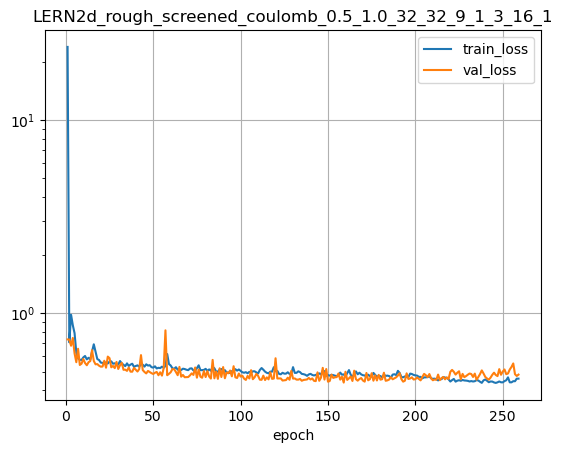

In [ ]:
n_hidden = n_hidden_best
n_neurons = n_neurons_best
seed = seed_best
N_feat = N_feat_best

run_name = f"LERN2d_" + data_regime + '_' + kernel_regime + f"_{qs}_{amp}_{N_x}_{N_y}_{N_feat}_{N_energy_terms}_{n_hidden}_{n_neurons}_{seed}"

path = ckpt_dir + f"/{run_name}_history.csv"
hist_df = pd.read_csv(path)
print(hist_df.head())
hist_df.plot(x="epoch", y=["train_loss", "val_loss"], logy=True, grid=True, title=run_name)

# # For saving data used in Figure 3
# data = np.column_stack([
#     hist_df["epoch"].to_numpy(),
#     hist_df["train_loss"].to_numpy(),
#     hist_df["val_loss"].to_numpy(),
# ])
# np.savetxt(f"Figure_3/hist_{data_regime}_{qs}.txt", data)

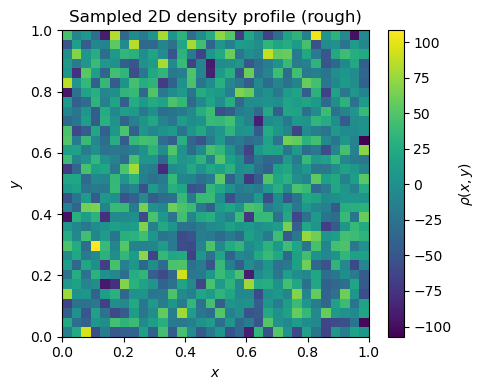

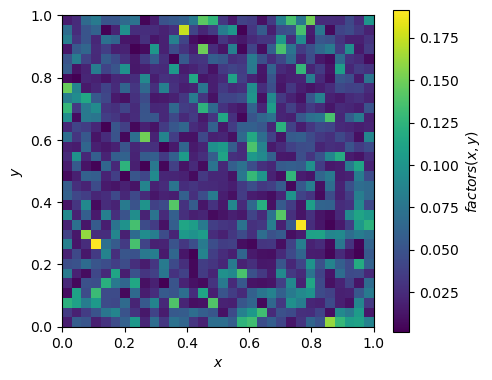

In [35]:
model, normalization, epoch, val_loss = load_checkpoint(
        ckpt_dir + f"/{run_name}_best.pt",
        LERN2d,
        device=device
    )
model = model.to(device=device, dtype=dtype)

k = 0  # index of the test sample to visualize
features_example = features_test_norm[k:k+1, :, :, :N_feat]  # (1, N_x, N_y, N_feat)
factors = model.local_nn(features_example) # (1, N_x, N_y, N_energy_terms)
rho_example = rho_test[k:k+1, :, :]  # (1, N_x, N_y)

plt.figure(figsize=(5, 4))
im = plt.imshow(
    rho_example.numpy().squeeze().T,              # transpose so x is horizontal, y vertical
    origin="lower",
    extent=[0, 1, 0, 1],   # x from 0 to 1, y from 0 to 1
    aspect="equal"
)
plt.colorbar(im, label=r"$\rho(x,y)$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
if data_regime == "rough":
    plt.title("Sampled 2D density profile (rough)")
elif data_regime == "smooth":
    plt.title("Sampled 2D density profile (smooth)")
plt.tight_layout()
plt.show()


plt.figure(figsize=(5, 4))
im = plt.imshow(
    factors.detach().numpy().squeeze().T,              # transpose so x is horizontal, y vertical
    origin="lower",
    extent=[0, 1, 0, 1],   # x from 0 to 1, y from 0 to 1
    aspect="equal"
)
plt.colorbar(im, label=r"$factors(x,y)$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
plt.show()

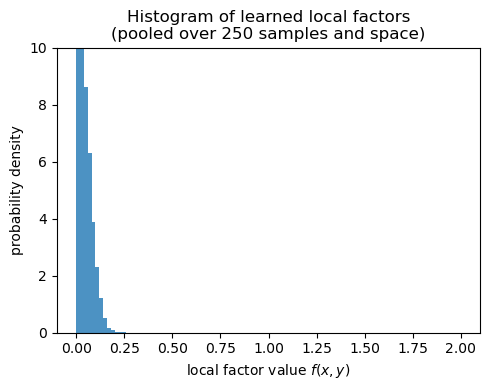

In [ ]:
dummy_factors = []
k = 0  # index of the test sample to visualize
for k in range(N_test):
    features_example = features_test_norm[k:k+1, :, :, :N_feat]  # (1, N_x, N_y, N_feat)
    factors = model.local_nn(features_example) # (1, N_x, N_y, 1)
    factors = factors.squeeze().view(-1) # (N_x * N_y,)
    dummy_factors.append(factors.detach().cpu().numpy())


all_factors = np.concatenate(dummy_factors, axis=0)
n_bins = 100   
bins = np.linspace(0.0, 2.0, n_bins + 1)

plt.figure(figsize=(5, 4))
plt.hist(
    all_factors,
    bins=bins,
    density=True,     # normalize → probability density
    alpha=0.8
)
plt.xlim(-0.1, 2.1)
plt.ylim(0, 10)
plt.xlabel(r"local factor value $f(x,y)$")
plt.ylabel("probability density")
plt.title(f"Histogram of learned local factors\n"
          rf"(pooled over {N_test} samples and space)")
plt.tight_layout()
plt.show()

# # For saving data used in Figure 3
# data = np.column_stack([all_factors])
# np.savetxt(f"Figure_3/factor_{data_regime}_{qs}.txt", data)